In [1]:
# %pip install pandas
# %pip install scikit-learn
# %pip install plotly
# %pip install seaborn
# %pip install numpy
# %pip install matplotlib
# %pip install nbformat
# %pip install opencv-python
# %pip install tensorflow
# %pip install wandb

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import cv2
import os
import plotly.express as px
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import wandb
%env "WANDB_NOTEBOOK_NAME" "model_balanced.ipynb"

wandb.login()

from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


env: "WANDB_NOTEBOOK_NAME"="model_balanced.ipynb"


wandb: Currently logged in as: pedro-mariani (dspro2-group9). Use `wandb login --relogin` to force relogin


In [3]:
label_df = pd.read_csv(
    "../../../data/processed/sentiment/sentiment_label.csv", index_col=False
)
data_dir = "../../../data/processed/sentiment/img/"

label_df.head()

,image_name,sentiment
0,angry_0.jpg,negative
1,angry_1.jpg,negative
2,fear_2.jpg,negative
3,happy_3.jpg,positive
4,angry_4.jpg,negative


In [4]:
def load_data(dir_path, img_size):
    X = []
    y = []

    for index, row in label_df.iterrows():
        image_path = os.path.join(dir_path, row["image_name"])
        img = cv2.imread(image_path)
        img = (
            cv2.resize(img, img_size, interpolation=cv2.INTER_AREA).astype("float32")
            / 255
        )
        X.append(img)
        y.append(row["sentiment"])

    X = np.array(X)
    y = np.array(y)
    return X, y

In [5]:
IMG_SIZE = (48, 48)

X, y = load_data(data_dir, IMG_SIZE)

In [7]:
dummies = pd.get_dummies(label_df["sentiment"])
dummies.head()

,negative,neutral,positive
0,True,False,False
1,True,False,False
2,True,False,False
3,False,False,True
4,True,False,False


In [8]:
y = dummies.values
y

array([[ True, False, False],
       [ True, False, False],
       [ True, False, False],
       ...,
       [ True, False, False],
       [False, False,  True],
       [ True, False, False]])

In [9]:
train_ratio = 0.80
test_ratio = 0.10
validation_ratio = 0.10


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=validation_ratio / (train_ratio + test_ratio)
)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(91714, 48, 48, 3)
(11465, 48, 48, 3)
(11465, 48, 48, 3)
(91714, 3)
(11465, 3)
(11465, 3)


# Distribution of classes in each set


In [10]:
class_count_in_train_set = np.sum(y_train, axis=0)

print("Class distribution:")
print(class_count_in_train_set)

Class distribution:
[28762 31263 31689]


In [11]:
labels = ["positive", "neutral", "negative"]
fig = px.bar(x=labels, y=class_count_in_train_set, color=labels)

fig.update_layout(
    title="Distribution of each label in train set",
    xaxis_title="Sentiments",
    yaxis_title="Count",
    height=600,
    width=800,
)

fig.update_traces(texttemplate="%{y}", textposition="inside")

fig.show()

In [12]:
class_count_in_validation_set = np.sum(y_valid, axis=0)

print("Class distribution:")
print(class_count_in_validation_set)

Class distribution:
[3647 3971 3847]


In [13]:
labels = ["positive", "neutral", "negative"]
fig = px.bar(x=labels, y=class_count_in_validation_set, color=labels)

fig.update_layout(
    title="Distribution of each label in validation set",
    xaxis_title="Sentiments",
    yaxis_title="Count",
    height=600,
    width=800,
)

fig.update_traces(texttemplate="%{y}", textposition="inside")

fig.show()

In [14]:
class_count_in_test_set = np.sum(y_test, axis=0)

print("Class distribution:")
print(class_count_in_test_set)

Class distribution:
[3602 3873 3990]


In [15]:
labels = ["positive", "neutral", "negative"]
fig = px.bar(x=labels, y=class_count_in_test_set, color=labels)

fig.update_layout(
    title="Distribution of each label in test set",
    xaxis_title="Sentiments",
    yaxis_title="Count",
    height=600,
    width=800,
)

fig.update_traces(texttemplate="%{y}", textposition="inside")

fig.show()

# Data augmentation to balance the dataset


In [ ]:
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True,
#     brightness_range=(0.8, 1.2),
#     zoom_range=0.1,
# )

# augmented_images = datagen.flow(X_train, y_train, batch_size=len(X_train))

# x_train_augmented = np.concatenate(
#     [
#         X_train,
#         augmented_images[0][0],
#     ]
# )
# y_train_augmented = np.concatenate(
#     [
#         y_train,
#         augmented_images[0][1],
#     ]
# )

# Model training


In [16]:
IMG_SIZE = (48, 48)

base_model = VGG16(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False

base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
NUM_CLASSES = 3

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(NUM_CLASSES, activation="softmax"))

In [18]:
wandb.init(
    # set the wandb project where this run will be logged
    project="Emotion Recognition",
    name="vgg16_three_sentiments_epoch5_batch32",
    # track hyperparameters and run metadata with wandb.config
    config={
        "optimizer": "Adam(learning_rate=3e-4)",
        "loss": "categorical_crossentropy",
        "metric": ["categorical_accuracy"],
        "epoch": 5,
        "batch_size": 32,
        "architecture": "vgg16",
    },
)

In [19]:
config = wandb.config


model.compile(
    loss=config["loss"],
    optimizer=Adam(learning_rate=3e-4),
    metrics=config["metric"],
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs=config["epoch"],
    batch_size=config["batch_size"],
    callbacks=[WandbMetricsLogger(log_freq=5)],
)


wandb.finish()

Epoch 1/5


wandb: ERROR Unable to log learning rate.


2867/2867 ━━━━━━━━━━━━━━━━━━━━ 228s 79ms/step - categorical_accuracy: 0.4394 - loss: 1.0716 - val_categorical_accuracy: 0.4898 - val_loss: 1.0117
Epoch 2/5
2867/2867 ━━━━━━━━━━━━━━━━━━━━ 223s 78ms/step - categorical_accuracy: 0.4825 - loss: 1.0146 - val_categorical_accuracy: 0.4927 - val_loss: 1.0039
Epoch 3/5
2867/2867 ━━━━━━━━━━━━━━━━━━━━ 224s 78ms/step - categorical_accuracy: 0.4973 - loss: 0.9976 - val_categorical_accuracy: 0.5041 - val_loss: 0.9961
Epoch 4/5
2867/2867 ━━━━━━━━━━━━━━━━━━━━ 222s 77ms/step - categorical_accuracy: 0.5044 - loss: 0.9910 - val_categorical_accuracy: 0.4994 - val_loss: 0.9978
Epoch 5/5
2867/2867 ━━━━━━━━━━━━━━━━━━━━ 221s 77ms/step - categorical_accuracy: 0.5147 - loss: 0.9779 - val_categorical_accuracy: 0.5072 - val_loss: 0.9908


batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
batch/categorical_accuracy,▁▃▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
batch/loss,█▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/categorical_accuracy,▁▄▆▇█
epoch/epoch,▁▃▅▆█
epoch/loss,█▄▃▂▁
epoch/val_categorical_accuracy,▁▂▇▅█
epoch/val_loss,█▅▃▃▁
batch/batch_step,14345
batch/categorical_accuracy,0.51427
batch/loss,0.97937


In [20]:
y_pred = model.predict(X_valid)
true_class = tf.argmax(y_valid, 1)
predicted_class = tf.argmax(y_pred, 1)

359/359 ━━━━━━━━━━━━━━━━━━━━ 24s 68ms/step


[Text(0, 0.5, 'positive'), Text(0, 1.5, 'neutral'), Text(0, 2.5, 'negative')]

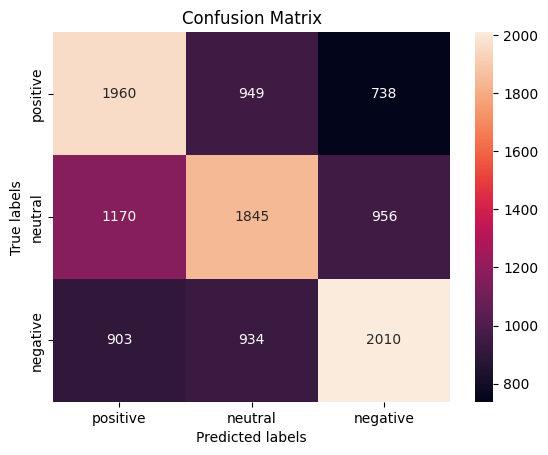

In [21]:
cm = confusion_matrix(true_class, predicted_class)

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt="g", ax=ax)

# labels, title and ticks
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(
    ["positive", "neutral", "negative"]
)
ax.yaxis.set_ticklabels(
    ["positive", "neutral", "negative"]
)